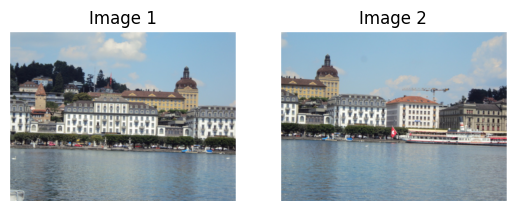

(-0.5, 1001.5, 374.5, -0.5)

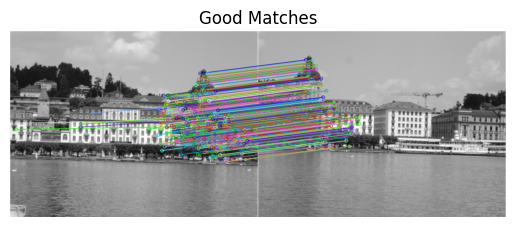

In [ ]:

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the first images
image1 = cv2.imread('left2.jpg')
image2 = cv2.imread('right2.jpg')


# Load the grayscale versions of the images
image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Convert BGR images to RGB format for displaying
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the pair of input images
plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.title('Image 1')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.title('Image 2')
plt.axis("off")

plt.show()


# Create SIFT object
sift = cv2.SIFT_create()

# Detect and compute keypoints and descriptors for the first image
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)

# Detect and compute keypoints and descriptors for the second image
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)


# Visualize the keypoints on the grayscale images
image1_keypoints = cv2.drawKeypoints(image1_gray, keypoints1, None)
image2_keypoints = cv2.drawKeypoints(image2_gray, keypoints2, None)

# Initialize the BFMatcher
bf = cv2.BFMatcher()

# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply the ratio test and determine good matches
good_matches = []
ratio_threshold = 0.5  # Threshold for the ratio test

for m, n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append([m])

# Draw the good matches
match_img = cv2.drawMatchesKnn(image1_gray, keypoints1, image2_gray, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.subplot(1, 1, 1)
plt.imshow(match_img)
plt.title("Good Matches")
plt.axis("off")




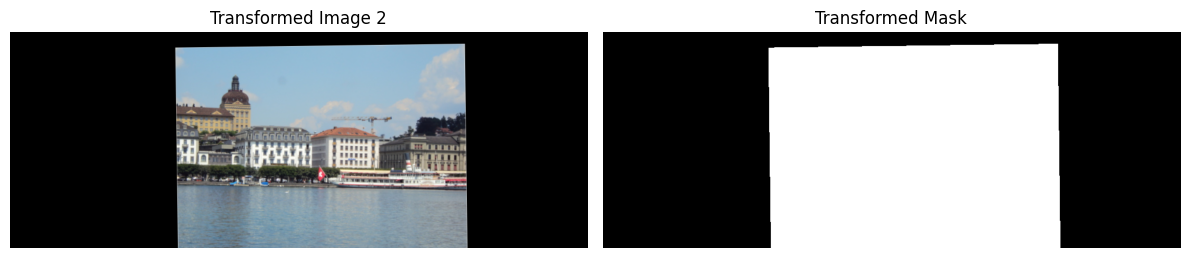

In [ ]:
# Create a BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Perform matching
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Take only the top n matches (e.g., n=50)
top_matches = matches[:50]

# Take the good matchings between the input images
matching_points1 = np.float32([keypoints1[m.queryIdx].pt for m in top_matches]).reshape(-1, 1, 2)
matching_points2 = np.float32([keypoints2[m.trainIdx].pt for m in top_matches]).reshape(-1, 1, 2)

# Calculate the dsize parameter
dsize = (image1_rgb.shape[1] + image2_rgb.shape[1], max(image1_rgb.shape[0], image2_rgb.shape[0]))

# Estimate the affine geometric transform
affine_transform, _ = cv2.estimateAffine2D(matching_points2, matching_points1)

# Transform the second image
transformed_image2 = cv2.warpAffine(image2_rgb, affine_transform, dsize, cv2.WARP_INVERSE_MAP )

# Create a mask image
mask = np.ones_like(image2_rgb)

# Transform the mask image and invert it
transformed_mask = cv2.warpAffine(mask, affine_transform, dsize ,  cv2.WARP_INVERSE_MAP)
transformed_mask[transformed_mask > 0] = 255

# Create a black background
black_background = np.zeros_like(transformed_mask)

# Visualize the transformed image with black background and white mask
masked_image = cv2.bitwise_or(black_background, transformed_mask)

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the transformed image in the left subplot
ax1.imshow(transformed_image2)
ax1.set_title('Transformed Image 2')
ax1.axis('off')

# Display the transformed mask in the right subplot
ax2.imshow(transformed_mask, cmap='gray')
ax2.set_title('Transformed Mask')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


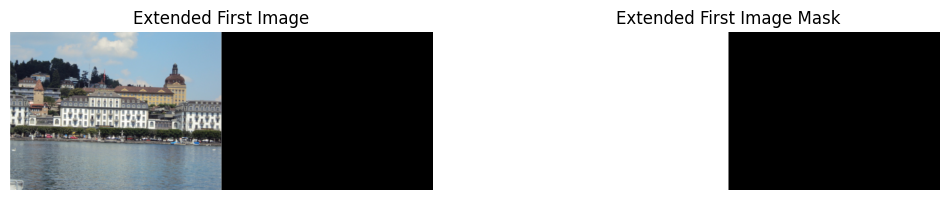

In [ ]:
# Get the dimensions of the transformed image
result_height, result_width = transformed_image2.shape[:2]

# Create a mask of zeros for the extended first image
mask_extended = np.zeros((result_height, result_width), dtype=np.uint8)

# Get the dimensions of the original first image
original_height, original_width = image1.shape[:2]

# Calculate the padding required to match the dimensions
padding_top = result_height - original_height
padding_right = result_width - original_width

# Extend the first image by padding it with zeros
extended_image1 = np.pad(image1_rgb, ((0, padding_top), (0, padding_right), (0, 0)), mode='constant')

# Create the mask for the extended part of the image
mask_extended[0:original_height, 0:original_width] = 255

# Visualize the extended first image and its corresponding mask
fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(12, 6))
ax1.imshow(extended_image1)
ax1.set_title('Extended First Image')
ax1.axis('off')
ax2.imshow(mask_extended, cmap='gray')
ax2.set_title('Extended First Image Mask')
ax2.axis('off')
plt.show()


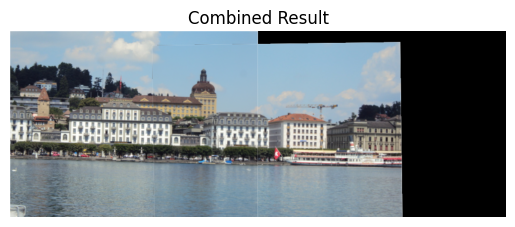

In [ ]:


# Combine the extended first image and the transformed second image by taking their average value
result = np.copy(extended_image1)  # Initialize the result with the extended first image

# Iterate over each pixel of the transformed image
for y in range(result_height):
    for x in range(int(result_width/2)):
        if np.any(transformed_mask[y, x] > 0):  # Check if any element in the array is greater than 0
            # Calculate the average value by taking the mean of corresponding pixels from both images
            result[y, x] = np.mean([result[y, x], transformed_image2[y, x]], axis=0)

# Iterate over each pixel of the transformed image
for y in range(result_height):
    for x in range(int(result_width/2), result_width):
        if np.any(transformed_mask[y, x] > 0):  # Check if any element in the array is greater than 0
            # Calculate the average value by taking the mean of corresponding pixels from both images
            result[y, x] = transformed_image2[y, x]

# Visualize the combination result
plt.imshow(result.astype(np.uint8))
plt.title('Combined Result')
plt.axis('off')
plt.show()